In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-01 15:21:18.604416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 15:21:18.609631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 15:21:18.610101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-01 15:21:18.893313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 15:21:18.894080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 15:21:18.894440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 15:21:18.894740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[1.99647200e+00, 1.88620853e+00, 0.00000000e+00],
         [1.51428413e+00, 1.91934705e-01, 2.03607655e+00],
         [8.54187191e-01, 0.00000000e+00, 5.16356714e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 8.13060641e-01],
         [2.15221047e+00, 6.21286154e-01, 0.00000000e+00],
         [1.42705858e-01, 0.00000000e+00, 0.00000000e+00]],

        [[1.31559002e+00, 0.00000000e+00, 0.00000000e+00],
         [1.49907064e+00, 2.15491486e+00, 2.02115440e+00],
         [0.00000000e+00, 0.00000000e+00, 2.48567119e-01],
         ...,
         [0.00000000e+00, 5.87612748e-01, 4.09181404e+00],
         [0.00000000e+00, 1.24388945e+00, 0.00000000e+00],
         [1.37236929e+00, 1.31040525e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.96267962e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.83174872e+00, 2.30591178e+00],
         ...,
         [0

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.99647200e+00, 1.88620853e+00, 0.00000000e+00],
          [1.51428413e+00, 1.91934705e-01, 2.03607655e+00],
          [8.54187191e-01, 0.00000000e+00, 5.16356714e-02],
          ...,
          [0.00000000e+00, 0.00000000e+00, 8.13060641e-01],
          [2.15221047e+00, 6.21286154e-01, 0.00000000e+00],
          [1.42705858e-01, 0.00000000e+00, 0.00000000e+00]],
 
         [[1.31559002e+00, 0.00000000e+00, 0.00000000e+00],
          [1.49907064e+00, 2.15491486e+00, 2.02115440e+00],
          [0.00000000e+00, 0.00000000e+00, 2.48567119e-01],
          ...,
          [0.00000000e+00, 5.87612748e-01, 4.09181404e+00],
          [0.00000000e+00, 1.24388945e+00, 0.00000000e+00],
          [1.37236929e+00, 1.31040525e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.96267962e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.83174872e+00, 2.30591178e+0

<IPython.core.display.Javascript object>


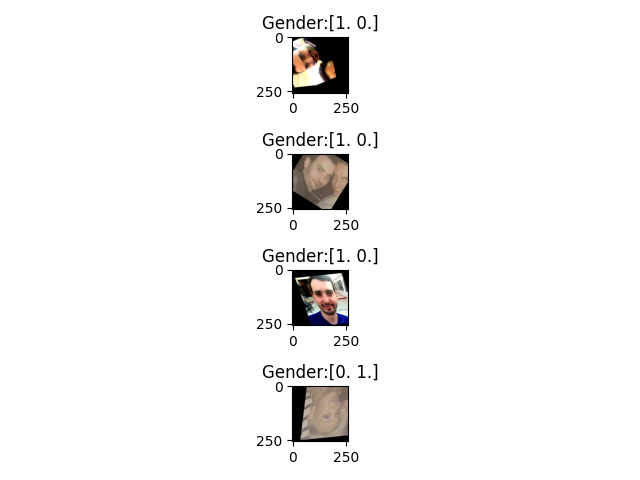

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 2, strides=(2,2), activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(8, 2, strides=(2,2), activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*8, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,8), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(32, 2, strides=(2,2), activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 2, strides=(2,2), activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    

    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_2')
    
    return model

In [33]:
LATENT_SIZE = 4

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 4)            45676       ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_2"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 700, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-01 15:21:32.713930: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 15:21:32.713948: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-01 15:21:32.714358: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-01 15:21:32.826133: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 15:21:32.827487: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 15:21:33.441490: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  17/3528 [..............................] - ETA: 11s - loss: 5613.3896 - gender_out_loss: 0.6945 - tf.math.multiply_1_loss: 5612.6953 - gender_out_accuracy: 0.4706    

2022-11-01 15:21:34.151108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 13s 3ms/step - loss: 5991.4453 - gender_out_loss: 0.6927 - tf.math.multiply_1_loss: 5990.7500 - gender_out_accuracy: 0.5221
Epoch 1/300
   1/1000 [..............................] - ETA: 12:43 - loss: 7730.8965 - gender_out_loss: 0.7090 - tf.math.multiply_1_loss: 7730.1875 - gender_out_accuracy: 0.2500

2022-11-01 15:21:46.493066: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 15:21:46.493147: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   9/1000 [..............................] - ETA: 1:09 - loss: 7609.0649 - gender_out_loss: 0.6977 - tf.math.multiply_1_loss: 7608.3682 - gender_out_accuracy: 0.5000

2022-11-01 15:21:47.061067: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-01 15:21:47.061912: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 15:21:47.095263: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2792 callback api events and 2751 activity events. 
2022-11-01 15:21:47.123192: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 15:21:47.168335: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47

2022-11-01 15:21:47.227859: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47/rachanon-pc1.trace.json.gz


  36/1000 [>.............................] - ETA: 26s - loss: 7002.7603 - gender_out_loss: 0.6838 - tf.math.multiply_1_loss: 7002.0762 - gender_out_accuracy: 0.5139

2022-11-01 15:21:47.271852: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47

2022-11-01 15:21:47.277327: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47/rachanon-pc1.memory_profile.json.gz
2022-11-01 15:21:47.278224: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47
Dumped tool data for xplane.pb to log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_2/log_0/plugins/profile/2022_11_01_15_21_47/ra

1000/1000 [==============================] - 19s 18ms/step - loss: 4109.3828 - gender_out_loss: 6.5187 - tf.math.multiply_1_loss: 4102.8647 - gender_out_accuracy: 0.4995 - val_loss: 3629.2886 - val_gender_out_loss: 1.1695 - val_tf.math.multiply_1_loss: 3628.1160 - val_gender_out_accuracy: 0.4861
Epoch 2/300
1000/1000 [==============================] - 17s 17ms/step - loss: 3141.3625 - gender_out_loss: 3.7008 - tf.math.multiply_1_loss: 3137.6604 - gender_out_accuracy: 0.5050 - val_loss: 3272.2820 - val_gender_out_loss: 0.9023 - val_tf.math.multiply_1_loss: 3271.3818 - val_gender_out_accuracy: 0.5353
Epoch 3/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2876.6655 - gender_out_loss: 2.2751 - tf.math.multiply_1_loss: 2874.3911 - gender_out_accuracy: 0.5272 - val_loss: 3201.0769 - val_gender_out_loss: 0.7240 - val_tf.math.multiply_1_loss: 3200.3479 - val_gender_out_accuracy: 0.5175
Epoch 4/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2841.0

1000/1000 [==============================] - 17s 17ms/step - loss: 2474.8020 - gender_out_loss: 0.6726 - tf.math.multiply_1_loss: 2474.1289 - gender_out_accuracy: 0.5817 - val_loss: 2817.3433 - val_gender_out_loss: 0.7362 - val_tf.math.multiply_1_loss: 2816.6069 - val_gender_out_accuracy: 0.5319
Epoch 28/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2609.2170 - gender_out_loss: 0.6951 - tf.math.multiply_1_loss: 2608.5251 - gender_out_accuracy: 0.5188 - val_loss: 2844.5134 - val_gender_out_loss: 0.6879 - val_tf.math.multiply_1_loss: 2843.8247 - val_gender_out_accuracy: 0.5441
Epoch 29/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2571.5093 - gender_out_loss: 0.6922 - tf.math.multiply_1_loss: 2570.8142 - gender_out_accuracy: 0.5110 - val_loss: 2854.5112 - val_gender_out_loss: 0.6925 - val_tf.math.multiply_1_loss: 2853.8198 - val_gender_out_accuracy: 0.5353
Epoch 30/300
1000/1000 [==============================] - 17s 17ms/step - loss: 261

1000/1000 [==============================] - 17s 17ms/step - loss: 2615.6809 - gender_out_loss: 0.6906 - tf.math.multiply_1_loss: 2614.9871 - gender_out_accuracy: 0.5245 - val_loss: 2850.9504 - val_gender_out_loss: 0.6877 - val_tf.math.multiply_1_loss: 2850.2507 - val_gender_out_accuracy: 0.5431
Epoch 54/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2555.1873 - gender_out_loss: 0.6933 - tf.math.multiply_1_loss: 2554.4932 - gender_out_accuracy: 0.5080 - val_loss: 2843.0916 - val_gender_out_loss: 0.7072 - val_tf.math.multiply_1_loss: 2842.3840 - val_gender_out_accuracy: 0.4768
Epoch 55/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2553.6580 - gender_out_loss: 0.6916 - tf.math.multiply_1_loss: 2552.9661 - gender_out_accuracy: 0.5217 - val_loss: 2818.5144 - val_gender_out_loss: 0.6871 - val_tf.math.multiply_1_loss: 2817.8281 - val_gender_out_accuracy: 0.5435
Epoch 56/300
1000/1000 [==============================] - 17s 17ms/step - loss: 256

1000/1000 [==============================] - 17s 17ms/step - loss: 2536.6536 - gender_out_loss: 0.6959 - tf.math.multiply_1_loss: 2535.9590 - gender_out_accuracy: 0.4945 - val_loss: 2831.3879 - val_gender_out_loss: 0.6961 - val_tf.math.multiply_1_loss: 2830.6931 - val_gender_out_accuracy: 0.5306
Epoch 80/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2480.2820 - gender_out_loss: 0.6761 - tf.math.multiply_1_loss: 2479.6057 - gender_out_accuracy: 0.5660 - val_loss: 2814.3840 - val_gender_out_loss: 0.7094 - val_tf.math.multiply_1_loss: 2813.6755 - val_gender_out_accuracy: 0.5353
Epoch 81/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2636.4197 - gender_out_loss: 0.6936 - tf.math.multiply_1_loss: 2635.7268 - gender_out_accuracy: 0.5353 - val_loss: 2845.5134 - val_gender_out_loss: 0.6905 - val_tf.math.multiply_1_loss: 2844.8201 - val_gender_out_accuracy: 0.5404
Epoch 82/300
1000/1000 [==============================] - 17s 17ms/step - loss: 260

1000/1000 [==============================] - 17s 17ms/step - loss: 2523.1111 - gender_out_loss: 0.6828 - tf.math.multiply_1_loss: 2522.4312 - gender_out_accuracy: 0.5608 - val_loss: 2838.9424 - val_gender_out_loss: 0.6873 - val_tf.math.multiply_1_loss: 2838.2563 - val_gender_out_accuracy: 0.5447
Epoch 106/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2564.9395 - gender_out_loss: 0.6913 - tf.math.multiply_1_loss: 2564.2480 - gender_out_accuracy: 0.5210 - val_loss: 2833.9160 - val_gender_out_loss: 0.6948 - val_tf.math.multiply_1_loss: 2833.2249 - val_gender_out_accuracy: 0.5354
Epoch 107/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2507.8528 - gender_out_loss: 0.6939 - tf.math.multiply_1_loss: 2507.1599 - gender_out_accuracy: 0.5038 - val_loss: 2813.4924 - val_gender_out_loss: 0.6930 - val_tf.math.multiply_1_loss: 2812.7971 - val_gender_out_accuracy: 0.5331
Epoch 108/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2631.0557 - gender_out_loss: 0.6868 - tf.math.multiply_1_loss: 2630.3667 - gender_out_accuracy: 0.5422 - val_loss: 2845.3765 - val_gender_out_loss: 0.6887 - val_tf.math.multiply_1_loss: 2844.6919 - val_gender_out_accuracy: 0.5368
Epoch 132/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2456.5496 - gender_out_loss: 0.6931 - tf.math.multiply_1_loss: 2455.8557 - gender_out_accuracy: 0.5085 - val_loss: 2830.5662 - val_gender_out_loss: 0.6924 - val_tf.math.multiply_1_loss: 2829.8770 - val_gender_out_accuracy: 0.5258
Epoch 133/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2446.1782 - gender_out_loss: 0.6769 - tf.math.multiply_1_loss: 2445.5007 - gender_out_accuracy: 0.5730 - val_loss: 2829.8623 - val_gender_out_loss: 0.6901 - val_tf.math.multiply_1_loss: 2829.1633 - val_gender_out_accuracy: 0.5424
Epoch 134/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2521.9990 - gender_out_loss: 0.6921 - tf.math.multiply_1_loss: 2521.3054 - gender_out_accuracy: 0.5150 - val_loss: 2816.1951 - val_gender_out_loss: 0.7016 - val_tf.math.multiply_1_loss: 2815.4934 - val_gender_out_accuracy: 0.5099
Epoch 158/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2535.4023 - gender_out_loss: 0.6797 - tf.math.multiply_1_loss: 2534.7231 - gender_out_accuracy: 0.5803 - val_loss: 2822.9395 - val_gender_out_loss: 0.6892 - val_tf.math.multiply_1_loss: 2822.2515 - val_gender_out_accuracy: 0.5390
Epoch 159/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2535.0483 - gender_out_loss: 0.6920 - tf.math.multiply_1_loss: 2534.3560 - gender_out_accuracy: 0.5232 - val_loss: 2841.9783 - val_gender_out_loss: 0.6888 - val_tf.math.multiply_1_loss: 2841.2876 - val_gender_out_accuracy: 0.5402
Epoch 160/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2607.9878 - gender_out_loss: 0.6806 - tf.math.multiply_1_loss: 2607.3103 - gender_out_accuracy: 0.5602 - val_loss: 2834.7771 - val_gender_out_loss: 0.6986 - val_tf.math.multiply_1_loss: 2834.0813 - val_gender_out_accuracy: 0.5136
Epoch 184/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2605.9634 - gender_out_loss: 0.6891 - tf.math.multiply_1_loss: 2605.2751 - gender_out_accuracy: 0.5395 - val_loss: 2859.5034 - val_gender_out_loss: 0.6938 - val_tf.math.multiply_1_loss: 2858.8000 - val_gender_out_accuracy: 0.5241
Epoch 185/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2495.0564 - gender_out_loss: 0.6919 - tf.math.multiply_1_loss: 2494.3645 - gender_out_accuracy: 0.5185 - val_loss: 2828.9326 - val_gender_out_loss: 0.6942 - val_tf.math.multiply_1_loss: 2828.2378 - val_gender_out_accuracy: 0.5246
Epoch 186/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2574.9019 - gender_out_loss: 0.6930 - tf.math.multiply_1_loss: 2574.2083 - gender_out_accuracy: 0.5220 - val_loss: 2822.7354 - val_gender_out_loss: 0.6932 - val_tf.math.multiply_1_loss: 2822.0432 - val_gender_out_accuracy: 0.5320
Epoch 210/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2468.7256 - gender_out_loss: 0.6909 - tf.math.multiply_1_loss: 2468.0337 - gender_out_accuracy: 0.5278 - val_loss: 2808.2185 - val_gender_out_loss: 0.6932 - val_tf.math.multiply_1_loss: 2807.5286 - val_gender_out_accuracy: 0.5382
Epoch 211/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2533.3567 - gender_out_loss: 0.6760 - tf.math.multiply_1_loss: 2532.6809 - gender_out_accuracy: 0.5825 - val_loss: 2843.6355 - val_gender_out_loss: 0.7020 - val_tf.math.multiply_1_loss: 2842.9265 - val_gender_out_accuracy: 0.5168
Epoch 212/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2539.2515 - gender_out_loss: 0.6897 - tf.math.multiply_1_loss: 2538.5645 - gender_out_accuracy: 0.5343 - val_loss: 2822.1475 - val_gender_out_loss: 0.6882 - val_tf.math.multiply_1_loss: 2821.4517 - val_gender_out_accuracy: 0.5404
Epoch 236/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2538.1216 - gender_out_loss: 0.6845 - tf.math.multiply_1_loss: 2537.4392 - gender_out_accuracy: 0.5405 - val_loss: 2849.0486 - val_gender_out_loss: 0.6925 - val_tf.math.multiply_1_loss: 2848.3608 - val_gender_out_accuracy: 0.5367
Epoch 237/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2569.2556 - gender_out_loss: 0.6871 - tf.math.multiply_1_loss: 2568.5669 - gender_out_accuracy: 0.5288 - val_loss: 2837.0659 - val_gender_out_loss: 0.6992 - val_tf.math.multiply_1_loss: 2836.3708 - val_gender_out_accuracy: 0.5179
Epoch 238/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2611.4045 - gender_out_loss: 0.6896 - tf.math.multiply_1_loss: 2610.7126 - gender_out_accuracy: 0.5410 - val_loss: 2809.4736 - val_gender_out_loss: 0.6875 - val_tf.math.multiply_1_loss: 2808.7913 - val_gender_out_accuracy: 0.5408
Epoch 262/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2563.6831 - gender_out_loss: 0.6933 - tf.math.multiply_1_loss: 2562.9919 - gender_out_accuracy: 0.5120 - val_loss: 2831.1335 - val_gender_out_loss: 0.6908 - val_tf.math.multiply_1_loss: 2830.4373 - val_gender_out_accuracy: 0.5399
Epoch 263/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2523.5442 - gender_out_loss: 0.6888 - tf.math.multiply_1_loss: 2522.8599 - gender_out_accuracy: 0.5405 - val_loss: 2819.8982 - val_gender_out_loss: 0.6878 - val_tf.math.multiply_1_loss: 2819.2078 - val_gender_out_accuracy: 0.5431
Epoch 264/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

1000/1000 [==============================] - 17s 17ms/step - loss: 2473.2261 - gender_out_loss: 0.6926 - tf.math.multiply_1_loss: 2472.5315 - gender_out_accuracy: 0.5192 - val_loss: 2811.4551 - val_gender_out_loss: 0.7009 - val_tf.math.multiply_1_loss: 2810.7546 - val_gender_out_accuracy: 0.5099
Epoch 288/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2468.7493 - gender_out_loss: 0.6826 - tf.math.multiply_1_loss: 2468.0664 - gender_out_accuracy: 0.5567 - val_loss: 2814.8596 - val_gender_out_loss: 0.6926 - val_tf.math.multiply_1_loss: 2814.1692 - val_gender_out_accuracy: 0.5441
Epoch 289/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2574.2798 - gender_out_loss: 0.6885 - tf.math.multiply_1_loss: 2573.5901 - gender_out_accuracy: 0.5328 - val_loss: 2813.2026 - val_gender_out_loss: 0.6904 - val_tf.math.multiply_1_loss: 2812.5120 - val_gender_out_accuracy: 0.5371
Epoch 290/300
1000/1000 [==============================] - 17s 17ms/step - loss: 

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[20.601294  , 17.402002  , 16.091408  ],
          [21.35832   , 18.62996   , 16.571846  ],
          [22.063873  , 19.1658    , 17.579323  ],
          ...,
          [ 0.08915082,  0.07129177,  0.06585047],
          [ 0.09514689,  0.07908136,  0.07809341],
          [ 0.0931026 ,  0.07715866,  0.0782986 ]],
 
         [[20.914055  , 17.56028   , 16.594273  ],
          [21.662045  , 18.42433   , 16.470922  ],
          [22.30111   , 19.2476    , 17.652857  ],
          ...,
          [ 0.08432508,  0.06372258,  0.06578207],
          [ 0.09580806,  0.0708662 ,  0.06877631],
          [ 0.08903682,  0.0819312 ,  0.07389084]],
 
         [[21.319197  , 18.565933  , 16.880146  ],
          [22.2117    , 19.318733  , 17.617641  ],
          [23.721504  , 20.30345   , 18.531439  ],
          ...,
          [ 0.0820908 ,  0.06687641,  0.07492438],
          [ 0.11115924,  0.08411989,  0.08141443],
          [ 0.

<IPython.core.display.Javascript object>


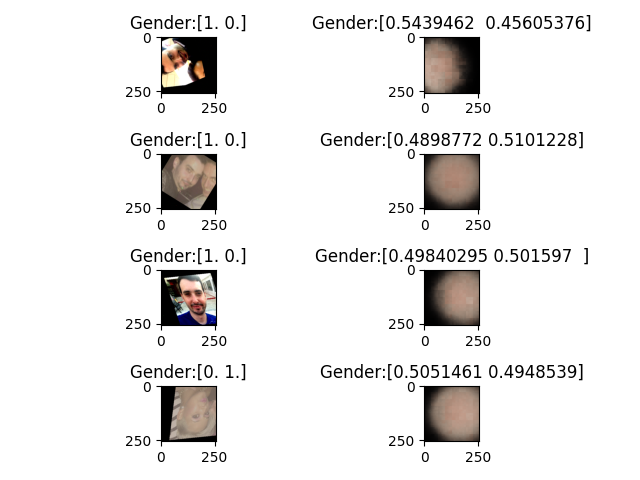

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()